In [1]:
library(tidyverse)
library(vroom)
library(cowplot)
theme_set(cowplot::theme_cowplot())
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [43]:
1-0.01

[1] 0.99

Rows: 2,023,763
Columns: 2
Delimiter: "\t"
dbl [2]: pos, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 835
Columns: 4
Delimiter: "\t"
chr [1]: chrom
dbl [3]: start, end, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 854,283
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: start, pos, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Warning message:
“Removed 1417 rows containing missing values (geom_point).”
Warning message:
“Removed 82 rows containing missing values (geom_point).”
Warning message:
“Removed 82 rows containing missing values (geom_segment).”


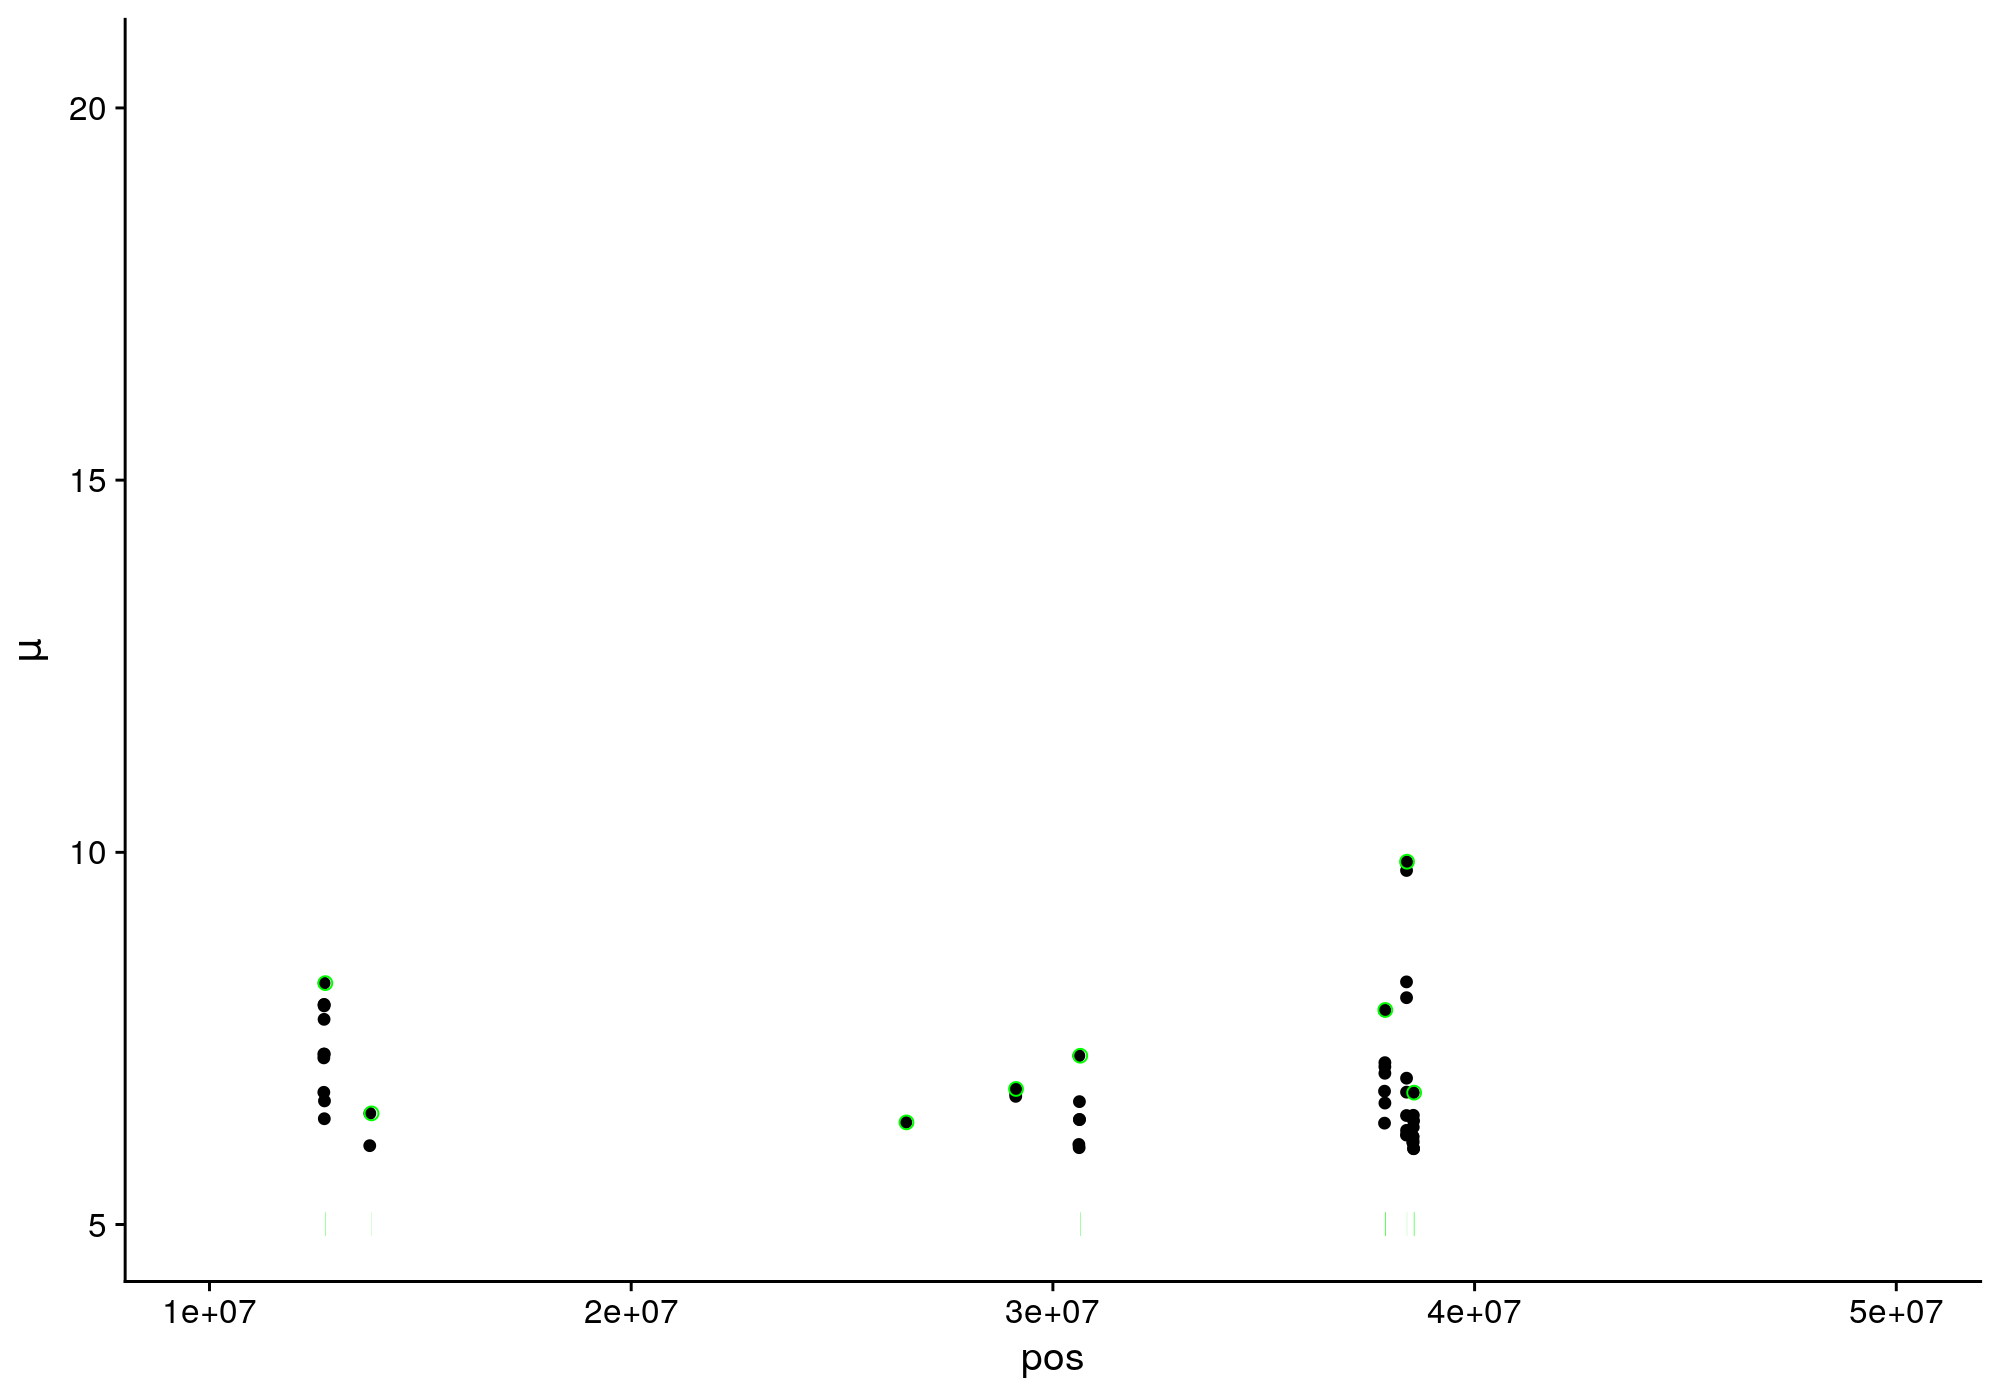

In [5]:
raisd_sim <- vroom("../data/dadi/RAiSD_Report.v5--LR--random1_Palmar_Chico_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_msprime", "\t", skip = 1, col_names = c("pos", "mu"))
q <- quantile(raisd_sim$mu, 0.99, na.rm = TRUE)

blocks <- vroom("../data/raisd/v5--LR--random1_Palmar_Chico.corrected_block_outliers_merged.txt", delim = "\t", 
                col_names = c("chrom", "start", "end", "mu")) %>% 
                filter(chrom == "chr3", mu > q)

outlier_df <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr3--0--238017767.corrected", delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu")) %>%
    filter(mu > q)

ggplot() +
    geom_point(data = outlier_df, mapping = aes(pos, mu)) +
    geom_point(data = blocks, mapping = aes((start + end)/2, mu), shape = 1, size = 2, colour = "green") +
    geom_segment(data = blocks, mapping = aes(x = start, xend = end, y = q-1, yend = q-1), lwd = 4, colour = "green") +
    ylab(expression(mu)) +
    xlim(1e7, 5e7)
    

Rows: 2,115,854
Columns: 2
Delimiter: "\t"
dbl [2]: pos, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



pos,mu
<dbl>,<dbl>
150,0.5273
160,0.7198
160,0.6846
165,0.6087
180,0.6410
180,0.6036


In [5]:
#raisd <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr10--0--152435371.txt", delim = "\t", skip = 1, 
#              col_names = c("pos", "start", "end", "var", "sfs", "ld", "mu")) %>% 
#              mutate(chrom = "chr10")    

raisd <- vroom("../data/raisd/RAiSD_Report.v5--Teo--Amatlan_de_Canas--chr2--0--243675191.corrected", delim = "\t", 
                 col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu")) %>% 
                select(-start, -end)

raisd_c <- vroom("../data/raisd/RAiSD_Report.v5--Teo--random1_Palmar_Chico--chr2--0--243675191.corrected", delim = "\t", 
                 col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu"))%>% 
                select(-start, -end)


raisd_j <- full_join(raisd, raisd_c, by = c("chrom", "pos"), suffix = c("_raw", "_corrected")) %>% drop_na()


Rows: 1,071,447
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,075,027
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



In [6]:
neutral <- 1
a <- ggplot() + geom_point(data = filter(raisd_j, mu_raw > neutral), mapping = aes(pos, mu_raw))
b <- ggplot() + geom_point(data = filter(raisd_j, mu_corrected > neutral), mapping = aes(pos, mu_corrected), colour = "red")

b   

ERROR: Error in filter(raisd_j, mu_raw > neutral): object 'raisd_j' not found


In [7]:
head(raisd)

chrom,pos,var,sfs,ld,mu
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr2,26572,0.769309,0.8515,1.979,1.29638
chr2,26576,0.769345,0.9224,2.028,1.43916
chr2,28744,0.774649,0.9224,2.028,1.44908
chr2,28840,0.765667,0.9224,2.028,1.43228
chr2,28858,0.763951,0.9224,2.028,1.42907
chr2,30911,0.582012,0.9934,2.028,1.17253



	Pearson's product-moment correlation

data:  raisd_j$mu_raw and raisd_j$mu_corrected
t = 17.802, df = 7390, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1808185 0.2245389
sample estimates:
      cor 
0.2027797 


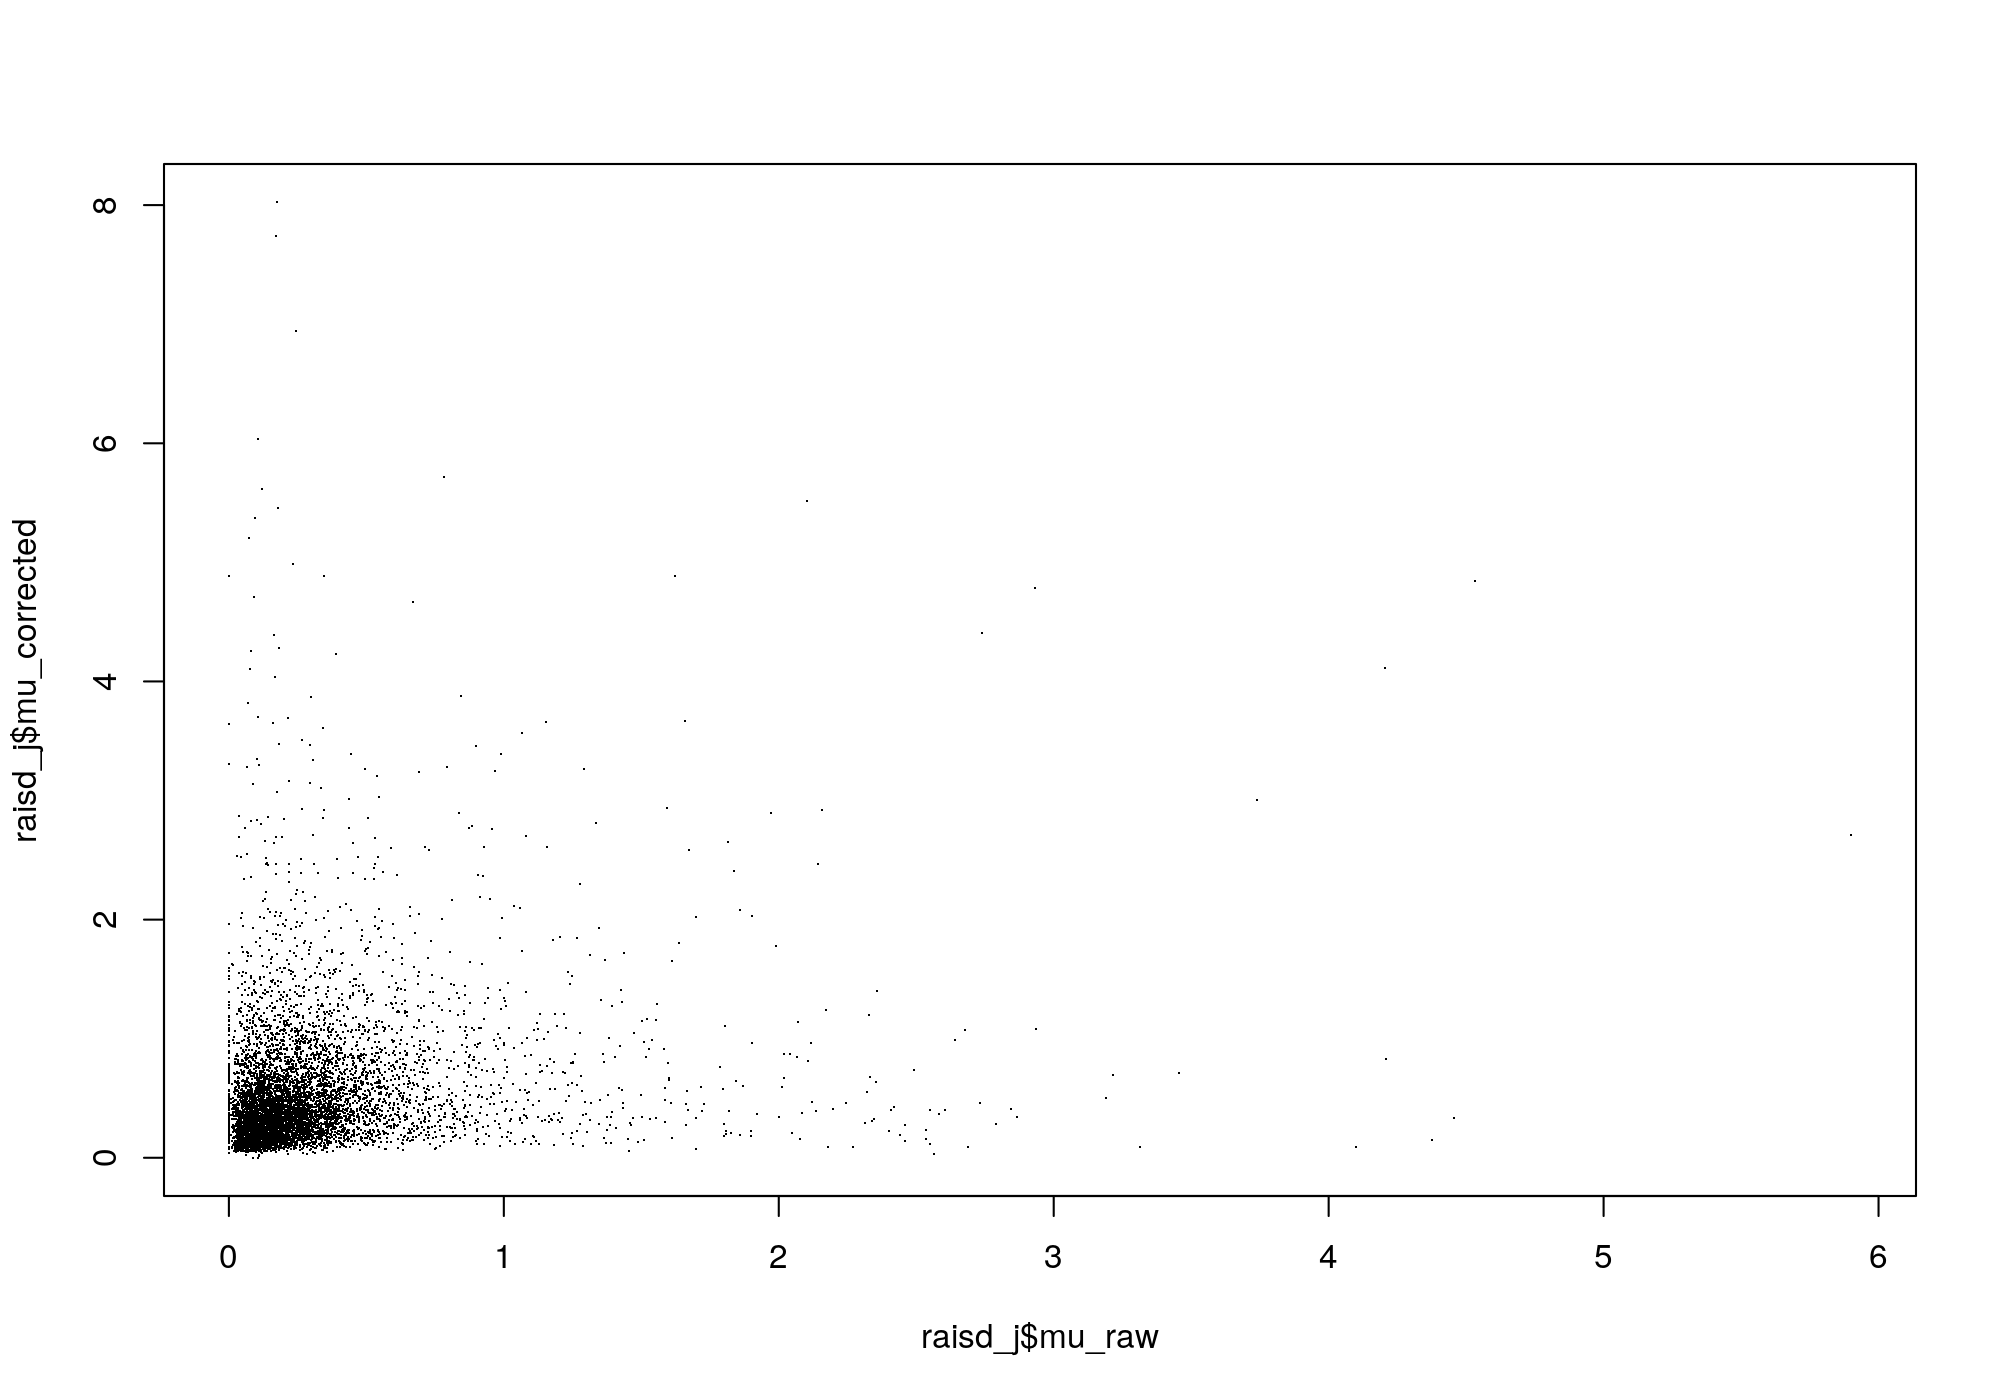

In [84]:
plot(raisd_j$mu_raw, raisd_j$mu_corrected, pch = ".")
cor.test(raisd_j$mu_raw, raisd_j$mu_corrected, method = "pe")

In [8]:
raisd_files <- sort(list.files(path = "../data/raisd/", pattern = "RAiSD_Report..*corrected", full.names = TRUE))
pop <- str_extract(raisd_files, "(v5|till1)--(LR|Teo)--(..*)--(chr[0-9][0.9]*)") %>%  str_replace("(LR|Teo)--(..*)--(chr[0-9][0.9]*)", "\\1--\\2") %>% unique()
qnt <- 0.99

pop_raised <- 
pop %>% 
    map_df(function(pop_i){
        pop_files <- sort(list.files(path = "../data/raisd/", pattern = str_glue("{pop_i}..*corrected"), full.names = TRUE))
        pop_files %>% 
        map_df(~{
            df  <- vroom(.x, delim = "\t", col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu"))
            if(nrow(df) > 0){
                ssp <- str_extract(.x, "(LR|Teo)--(..*)--(chr[0-9][0.9]*)") %>%  str_replace("(LR|Teo)--(..*)--(chr[0-9][0.9]*)", "\\1")
                pop <- str_extract(.x, "(LR|Teo)--(..*)--(chr[0-9][0.9]*)") %>%  str_replace("(LR|Teo)--(..*)--(chr[0-9][0.9]*)", "\\2")
                mutate(df, ssp_pop = str_glue("{ssp}_{pop}"), ssp = ssp, pop = pop)
            } else{
                tibble()
            }
        }) %>% 
        mutate(mu_outlier = quantile(mu, qnt)) %>% 
        filter(mu >= mu_outlier)
})

Rows: 1,360,704
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 163
Columns: 4
Delimiter: "\t"
chr [1]: chrom
dbl [3]: pos, start, end

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 737,217
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 86
Columns: 4
Delimiter: "\t"
chr [1]: chrom
dbl [3]: pos, start, end

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,139,753
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retri

In [77]:
head(pop_raised)

chrom,pos,start,end,var,sfs,ld,mu,ssp_pop,ssp,pop,mu_outlier
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<glue>,<chr>,<chr>,<dbl>
chr1,24526,15285,33766,1.49616,1.632,1.779,4.34383,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,24564,15299,33829,1.50018,1.632,1.612,3.94666,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,24632,15400,33863,1.49534,1.632,1.612,3.93391,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,24639,15411,33866,1.49533,1.632,1.604,3.91437,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,25139,15834,34444,1.54663,1.632,1.544,3.89720,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,25193,15859,34526,1.55383,1.561,1.917,4.64975,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711


In [79]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("IRanges")

BiocManager::install("GenomicRanges")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'IRanges'

also installing the dependencies ‘BiocGenerics’, ‘S4Vectors’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'backports', 'brms', 'broom', 'callr', 'data.table', 'digest',
  'DT', 'foreach', 'generics', 'globals', 'googlePolylines', 'iterators',
  'KernSmooth', 'labeling', 'lwgeom', 'nlme', 'pbdZMQ', 'R6', 'readr',
  'recipes', 'rmarkdown', 'sfheaders', 'sp', 'SQUAREM', 'stars', 'testthat',
  'tinytex', 'tmap', 'tmaptools', 'V8', 'xfun'



ERROR: Error: With R version 3.5 or greater, install Bioconductor packages using BiocManager; see https://bioconductor.org/install
